# 範例 : (Kaggle)房價預測

# [教學目標]
- 以下用房價預測資料, 練習特徵重要性的寫作與觀察
- 由於只有樹狀模型有特徵重要性, 故以隨機森林為模型作為範例

# [範例重點]
- 使用擬合過的模型, 計算特徵重要性 (In[4], Out[4]) 
- 對照原始特徵, 觀察特徵重要性較高的一半特徵, 搭配隨機森林對於測結果的影響 (In[5], Out[5], In[6], Out[6])
- 重組重要性最高的特徵作為新特徵, 觀察效果如何 (In[9], Out[9]) 

In [9]:
# 請先確認您的 sklearn 版本是否相同, 如果版本不是 0.21.1 版, 有可能跑出與本範例不同的結果
import sklearn
sklearn.__version__

'0.22.1'

In [13]:
# 做完特徵工程前的所有準備
import pandas as pd
import numpy as np
import copy
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

data_path = 'data/'
df = pd.read_csv(data_path + 'house_train.csv.gz')

train_Y = np.log1p(df['SalePrice'])
df = df.drop(['Id', 'SalePrice'] , axis=1)
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [15]:
# 因為需要把類別型與數值型特徵都加入, 故使用最簡版的特徵工程
LEncoder = LabelEncoder()
MMEncoder = MinMaxScaler()
for c in df.columns:
    df[c] = df[c].fillna(-1)
    if df[c].dtype == 'object':
        print(c,set(df[c]),'\n')
        df[c] = LEncoder.fit_transform(list(df[c].values))
    df[c] = MMEncoder.fit_transform(df[c].values.reshape(-1, 1))
df.head()

MSZoning {'RL', 'C (all)', 'FV', 'RM', 'RH'} 

Street {'Pave', 'Grvl'} 

Alley {'Pave', 'Grvl', -1} 

LotShape {'IR2', 'IR1', 'IR3', 'Reg'} 

LandContour {'Low', 'Bnk', 'Lvl', 'HLS'} 

Utilities {'NoSeWa', 'AllPub'} 

LotConfig {'FR3', 'FR2', 'Corner', 'CulDSac', 'Inside'} 

LandSlope {'Gtl', 'Sev', 'Mod'} 

Neighborhood {'Crawfor', 'SawyerW', 'NWAmes', 'BrDale', 'OldTown', 'NAmes', 'NPkVill', 'MeadowV', 'Gilbert', 'StoneBr', 'Veenker', 'Edwards', 'IDOTRR', 'ClearCr', 'Blueste', 'CollgCr', 'Mitchel', 'NoRidge', 'Sawyer', 'SWISU', 'NridgHt', 'Blmngtn', 'BrkSide', 'Timber', 'Somerst'} 

Condition1 {'PosA', 'RRNn', 'RRAe', 'PosN', 'Norm', 'RRAn', 'RRNe', 'Feedr', 'Artery'} 

Condition2 {'PosA', 'RRNn', 'RRAe', 'PosN', 'Norm', 'RRAn', 'Feedr', 'Artery'} 

BldgType {'2fmCon', 'TwnhsE', '1Fam', 'Twnhs', 'Duplex'} 

HouseStyle {'1.5Unf', '2.5Fin', 'SLvl', '2.5Unf', '1.5Fin', '2Story', 'SFoyer', '1Story'} 

RoofStyle {'Mansard', 'Gable', 'Hip', 'Gambrel', 'Flat', 'Shed'} 

RoofMatl {'Roll', 'C

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.235294,0.75,0.210191,0.033420,1.0,0.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.50,1.0,0.8
1,0.000000,0.75,0.257962,0.038795,1.0,0.0,1.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.363636,0.25,1.0,0.8
2,0.235294,0.75,0.219745,0.046507,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.727273,0.50,1.0,0.8
3,0.294118,0.75,0.194268,0.038561,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.00,1.0,0.0
4,0.235294,0.75,0.270701,0.060576,1.0,0.0,0.0,1.0,0.0,0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.50,1.0,0.8


In [17]:
# 隨機森林擬合後, 將結果依照重要性由高到低排序
estimator = RandomForestRegressor()
estimator.fit(df.values, train_Y)
# estimator.feature_importances_ 就是模型的特徵重要性, 這邊先與欄位名稱結合起來, 才能看到重要性與欄位名稱的對照表
feats = pd.Series(data=estimator.feature_importances_, index=df.columns)
feats = feats.sort_values(ascending=False)
print(feats.sum())
feats

0.9999999999999999


OverallQual    0.559082
GrLivArea      0.102962
TotalBsmtSF    0.046546
GarageArea     0.034495
GarageCars     0.028421
                 ...   
Street         0.000062
MiscFeature    0.000049
Condition2     0.000039
PoolArea       0.000014
Utilities      0.000004
Length: 79, dtype: float64

In [25]:
# 原始特徵 + 隨機森林
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8727489634476935

In [26]:
# 高重要性特徵 + 隨機森林 (39大約是79的一半)
high_feature = list(feats[:39].index)
train_X = MMEncoder.fit_transform(df[high_feature])
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8744597023370828

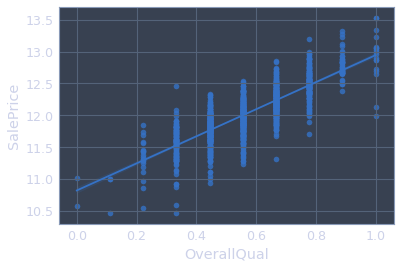

In [20]:
# 觀察重要特徵與目標的分布
# 第一名 : OverallQual              
import seaborn as sns
import matplotlib.pyplot as plt
sns.regplot(x=df['OverallQual'], y=train_Y, fit_reg=True)
plt.show()

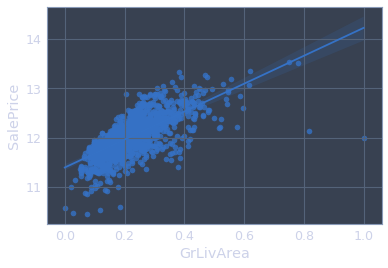

In [24]:
# 第二名 : GrLivArea
sns.regplot(x=df['GrLivArea'], y=train_Y, fit_reg=True)
plt.show()

In [27]:
# 製作四特徵 : 加, 乘, 互除(分母加1避免除0) 看效果 (Note: 數值原本已經最大最小化介於 [0,1] 區間, 這四種新特徵也會落在 [0,1] 區間)
df['Add_char'] = (df['GrLivArea'] + df['OverallQual']) / 2
df['Multi_char'] = df['GrLivArea'] * df['OverallQual']
df['GO_div1p'] = df['GrLivArea'] / (df['OverallQual']+1) * 2
df['OG_div1p'] = df['OverallQual'] / (df['GrLivArea']+1) * 2
train_X = MMEncoder.fit_transform(df)
cross_val_score(estimator, train_X, train_Y, cv=5).mean()

0.8716050660185817

## 先用隨機森林對鐵達尼生存預測做訓練，再用其特徵重要性回答下列問題

# 作業1
* 將特徵重要性較低的一半特徵刪除後，再做生存率預估，正確率是否有變化?

# 作業2
* 將特徵重要性最高的兩個特徵做特徵組合，是否能再進一步提升預測力?